In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from mpl_toolkits.mplot3d import Axes3D

In [2]:
file_path = "../dataset/sequences/00/image_0/"
left_images = os.listdir(file_path)

In [3]:
left_images[:5]

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png']

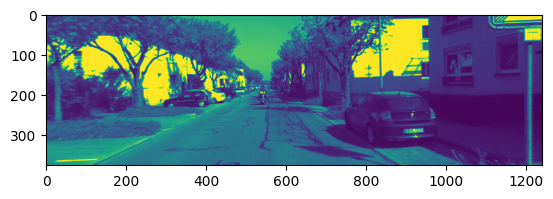

In [4]:
plt.imshow(cv2.imread(file_path+left_images[0], 0))

In [5]:
image = cv2.imread(file_path+left_images[0], 0)
image.shape

(376, 1241)

In [6]:
file_path_lidar = '../dataset/sequences/00/'
velodyne_files = os.listdir(file_path_lidar+'velodyne')
pointcloud = np.fromfile(file_path_lidar+'velodyne/'+velodyne_files[0], dtype=np.float32)

In [7]:
pointcloud = pointcloud.reshape((-1,4))
pointcloud.shape

(124668, 4)

In [8]:
pointcloud.dtype

dtype('float32')

In [9]:
# %matplotlib notebook
%matplotlib inline

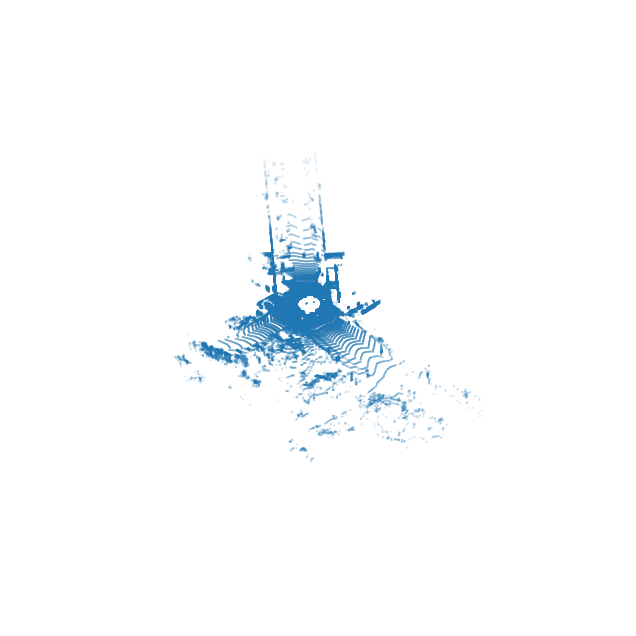

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

xs = pointcloud[:, 0]#[::20]
ys = pointcloud[:, 1]#[::20]
zs = pointcloud[:, 2]#[::20]

ax.set_box_aspect([np.ptp(xs), np.ptp(ys), np.ptp(zs)])
ax.scatter(xs, ys, zs, s=0.01)
ax.grid(False)
ax.axis('off')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(elev=40, azim=180)

In [11]:
calib = pd.read_csv('../dataset/sequences/00/calib.txt', delimiter=' ', header=None, index_col = 0)
print(calib)
Tr = np.array(calib.iloc[4]).reshape((3,4))
print(Tr)

             1         2           3           4         5           6   \
0                                                                         
P0:  718.856000  0.000000  607.192800    0.000000  0.000000  718.856000   
P1:  718.856000  0.000000  607.192800 -386.144800  0.000000  718.856000   
P2:  718.856000  0.000000  607.192800   45.382250  0.000000  718.856000   
P3:  718.856000  0.000000  607.192800 -337.287700  0.000000  718.856000   
Tr:    0.000428 -0.999967   -0.008084   -0.011985 -0.007211    0.008081   

             7         8         9         10        11        12  
0                                                                  
P0:  185.215700  0.000000  0.000000  0.000000  1.000000  0.000000  
P1:  185.215700  0.000000  0.000000  0.000000  1.000000  0.000000  
P2:  185.215700 -0.113089  0.000000  0.000000  1.000000  0.003780  
P3:  185.215700  2.369057  0.000000  0.000000  1.000000  0.004915  
Tr:   -0.999941 -0.054040  0.999974  0.000486 -0.007207 -0.292197 

In [12]:
class Dataset_Handler():
    def __init__(self, sequence, lidar=True, low_memory=True):
        self.lidar = lidar
        self.low_memory = low_memory
        self.seq_dir = "../dataset/sequences/{}/".format(sequence)
        self.poses_dir = "../dataset/poses/{}.txt".format(sequence)
        
        poses = pd.read_csv(self.poses_dir, delimiter= ' ', header=None)
        
        self.left_image_files = os.listdir(self.seq_dir+'image_0')
        self.right_image_files = os.listdir(self.seq_dir+'image_1')
        self.velodyne_files = os.listdir(self.seq_dir+'velodyne')
        
        #self.left_image_files = os.listdir(self.seq_dir+'image_0')
        
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir + 'velodyne/'
        
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        self.gt = np.zeros((self.num_frames, 3, 4))
        
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape(3,4)
            
        calib = pd.read_csv(self.seq_dir+'calib.txt', delimiter=' ', header=None, index_col = 0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        if low_memory:
            self.reset_frames()
            self.first_image_left = cv2.imread(self.seq_dir+'image_0/'+ self.left_image_files[0], 0)
            self.first_image_right = cv2.imread(self.seq_dir+'image_1/'+ self.right_image_files[0], 0)
            self.second_image_left = cv2.imread(self.seq_dir+'image_0/'+ self.left_image_files[1], 0)
            if self.lidar:
                self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0], dtype=np.float32, count=-1).reshape((-1, 4))
            self.imheight = self.first_image_left.shape[0]
            self.imwidth = self.first_image_left.shape[1]
            
        else:
            self.images_left = []
            self.images_right = []
            self.pointclouds = []
            for i, name_left in enumerate(self.left_image_files):
                name_right = self.right_image_files[i]
                self.images_left.append(cv2.imread(self.seq_dir+'image_0/'+name_left,0))
                self.images_right.append(cv2.imread(self.seq_dir+'image_1/'+name_right,0))
                if self.lidar:
                    pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[i], dtype=np.float32, count=-1).reshape((-1, 4))
                    self.pointclouds.append(pointcloud)
                self.imheight = self.images_left[0].shape[0]
                self.imwidth = self.images_right[0].shape[1]
            
    def reset_frames(self):
        self.images_left = (cv2.imread(self.seq_dir+'image_0/'+name_left, 0) for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir+'image_0/'+name_right, 0) for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, dtype=np.float32).reshape((-1,4)) for velodyne_file in self.velodyne_files)
        pass

In [13]:
seq_dir = "../dataset/sequences/00/"
calib = pd.read_csv(seq_dir+'calib.txt', delimiter=' ', header=None, index_col=0)
P0 = np.array(calib.loc['P0:']).reshape((3,4))
P1 = np.array(calib.loc['P1:']).reshape((3,4))
P2 = np.array(calib.loc['P2:']).reshape((3,4))
P3 = np.array(calib.loc['P3:']).reshape((3,4))
Tr = np.array(calib.loc['Tr:']).reshape((3,4))

In [14]:
# handler = Dataset_Handler('00', low_memory=False)

In [15]:
handler2= Dataset_Handler('00')

In [16]:
handler2.first_image_left.shape

(376, 1241)

In [17]:
%matplotlib inline

In [18]:
# plt.imshow(handler.images_left[0])

In [19]:
# plt.figure(figsize=(11,7))
# plt.imshow(handler.images_left[0])

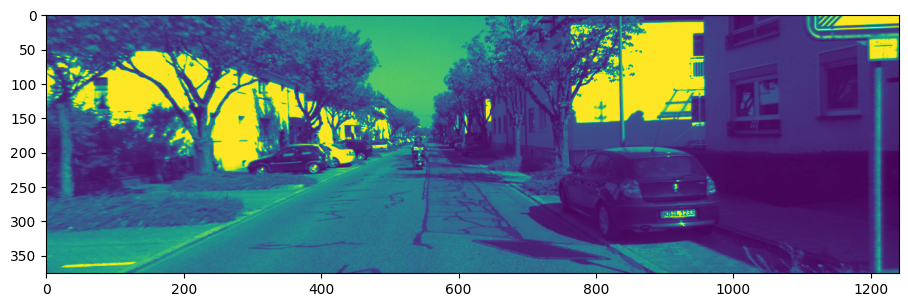

In [20]:
plt.figure(figsize=(11,7))
plt.imshow(next(handler2.images_left))

In [21]:
def compute_left_disparity_map(image_left, image_right, matcher='bm', rgb=False, verbose=False):
    sad_window = 6
    num_disparities = sad_window * 16
    matcher_name = matcher
    block_size = 11
    
    if matcher_name =='bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=block_size)
        
    elif matcher_name == 'sgbm':
        # matcher = cv2.StereoSGBM_create(numDisparities=num_disparities, minDisparity =0, blockSize=block_size, 
        #                                P1 = 8 * 3 * sad_window ** 2, P2 = 32 * 3 * sad_window ** 2,
        #                                mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY)
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities, minDisparity =0, blockSize=block_size, 
                                       P1 = 8 * 1 * block_size ** 2, P2 = 32 * 1 * block_size ** 2,
                                       mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY)
        
    if rgb:
        image_left = cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY)
        image_right = cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY)
        
    start = datetime.datetime.now()
    disp_left = matcher.compute(image_left, image_right).astype(np.float32)/16
    print("Data type of disparity map: ", type(disp_left))
    end = datetime.datetime.now()
    
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}', end-start)
        
    
    return disp_left

Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoBM 0:00:00.017816


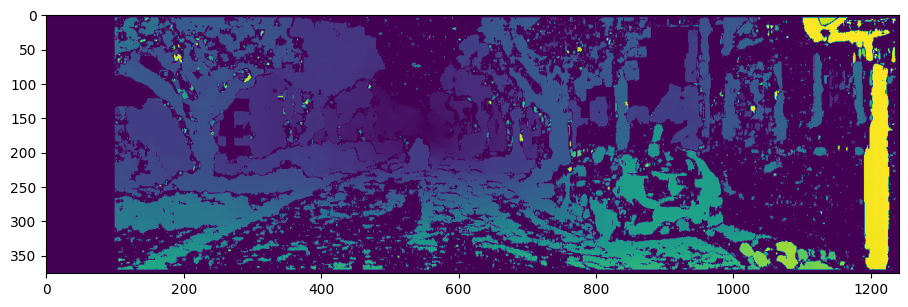

In [22]:
disp = compute_left_disparity_map(handler2.first_image_left, handler2.first_image_right, matcher='bm', verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp)

Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.034225


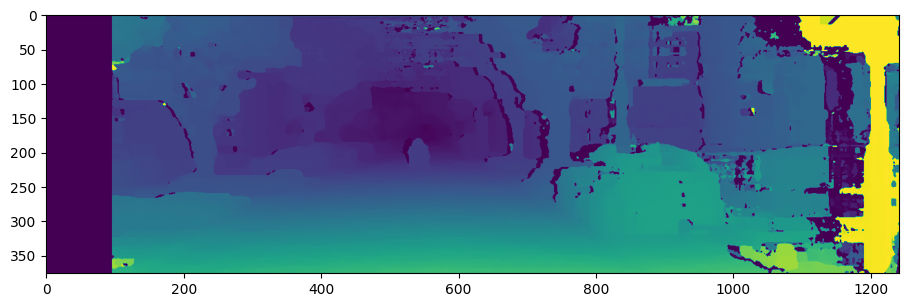

In [23]:
disp = compute_left_disparity_map(handler2.first_image_left, handler2.first_image_right, matcher='sgbm', verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp)

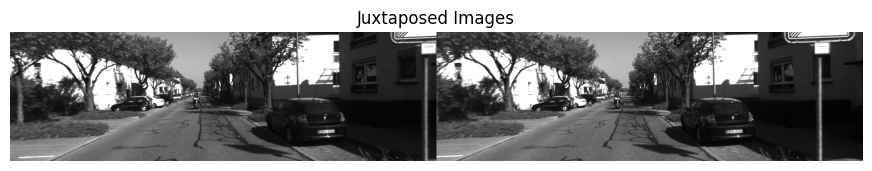

In [24]:
image_left = handler2.first_image_left
image_right = handler2.first_image_right
concatenated_image = np.hstack((image_left, image_right))
plt.figure(figsize=(11,11))
plt.imshow(concatenated_image, cmap='gray')  # Use the 'gray' colormap if the images are grayscale
plt.title('Juxtaposed Images')
plt.axis('off')  # Optionally turn off the axis
plt.show()


In [25]:
print(disp.shape)

(376, 1241)


In [26]:
k,r,t,_,_,_,_ = cv2.decomposeProjectionMatrix(handler2.P0)
print(k)
print(r)
print(t)

[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[0.]
 [0.]
 [0.]
 [1.]]


In [27]:
def decompose_projection_matrix(p):
    k,r,t,_,_,_,_ = cv2.decomposeProjectionMatrix(p)
    t = (t/t[3])[:3]
    return k,r,t

In [28]:
def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    if rectified:
        b = t_right[0] - t_left[0]
    else:
        b = t_left[0] - t_right[0]
        
    f = k_left[0][0]
    
    disp_left[disp_left==0] = 0.1
    disp_left[disp_left==-1] = 0.1
    
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [29]:
k_left, r_left, t_left = decompose_projection_matrix(handler2.P0)
k_right, r_right, t_right = decompose_projection_matrix(handler2.P1)

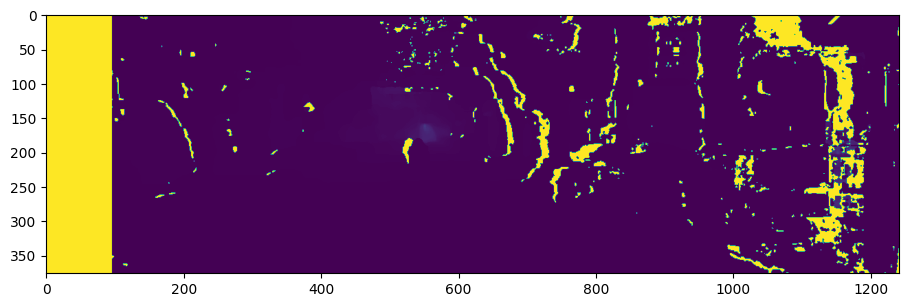

In [30]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.imshow(depth)

In [31]:
depth[0,0]

3861.447942459941

In [32]:
# pip install jupyterthemes

In [33]:
from jupyterthemes import jtplot
jtplot.style()

(array([406059.,    636.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  59921.]),
 array([   4.06468211,  389.80300814,  775.54133418, 1161.27966021,
        1547.01798625, 1932.75631228, 2318.49463832, 2704.23296435,
        3089.97129039, 3475.70961642, 3861.44794246]),
 <BarContainer object of 10 artists>)

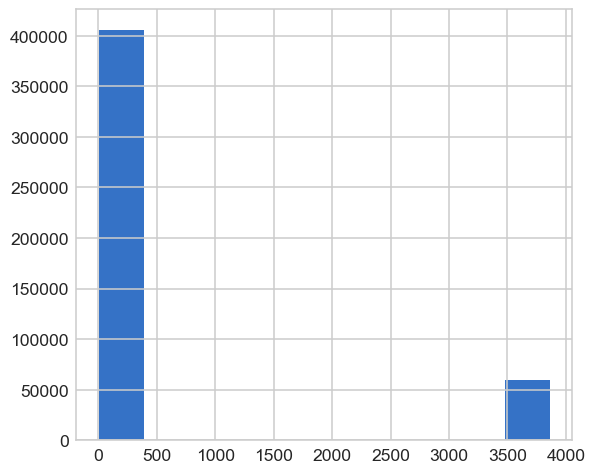

In [34]:
plt.hist(depth.flatten())

In [35]:
depth[depth<depth.max()].flatten().max()

686.4796444444443

In [36]:
for i, pixel in enumerate(depth[0]):
    if pixel < depth.max():
        print(f"First non-max value at {i}")
        break

First non-max value at 96


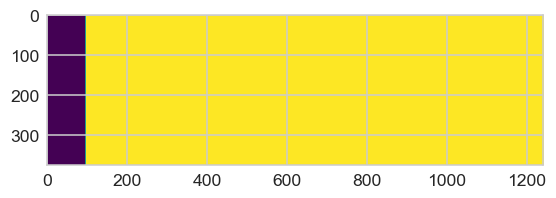

In [37]:
mask = np.zeros(depth.shape, dtype=np.uint8)
ymax = depth.shape[0]
xmax = depth.shape[1]
cv2.rectangle(mask, (96,0), (xmax, ymax), 255, thickness=-1)
plt.imshow(mask)

In [38]:
def stereo_to_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=True, rectified = True):
    disp = compute_left_disparity_map(img_left, img_right, matcher=matcher, rgb=rgb, verbose=verbose)
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    depth = calc_depth_map(disp,k_left, t_left, t_right)
    return depth

Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.040214


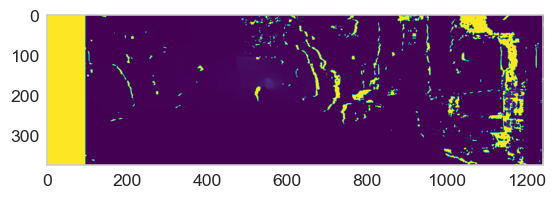

In [39]:
stereo_depth = stereo_to_depth(handler2.first_image_left, handler2.first_image_right, handler2.P0, handler2.P1, matcher='sgbm', rgb=False, verbose=True)
plt.grid(False)
plt.imshow(depth)

In [40]:
handler2.first_pointcloud.shape

(124668, 4)

In [41]:
handler2.Tr.round(4)

array([[ 4.000e-04, -1.000e+00, -8.100e-03, -1.200e-02],
       [-7.200e-03,  8.100e-03, -9.999e-01, -5.400e-02],
       [ 1.000e+00,  5.000e-04, -7.200e-03, -2.922e-01]])

In [42]:
pcloud = handler2.first_pointcloud
print('Pointcloud shape: ', pcloud.shape)
trimmed_pcloud = pcloud[pcloud[:, 0] > 0]
print('Trimmed pointcloud shape: ', trimmed_pcloud.shape)

Pointcloud shape:  (124668, 4)
Trimmed pointcloud shape:  (63141, 4)


In [43]:
homogenours_pcloud = np.hstack([trimmed_pcloud[:,:3], np.ones(trimmed_pcloud.shape[0]).reshape((-1,1))])
cam_xyz = handler2.Tr.dot(trimmed_pcloud.T)
cam_xyz /= cam_xyz[2]
cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
projection = handler2.P0.dot(cam_xyz)
projection[:, :10].T

array([[606.95511898, 152.8019536 ,   1.        ],
       [604.70040658, 152.93682998,   1.        ],
       [602.44536092, 152.95541569,   1.        ],
       [594.44678898, 153.74404704,   1.        ],
       [592.19822941, 153.75570653,   1.        ],
       [589.92618639, 153.8383493 ,   1.        ],
       [587.66755433, 153.81495302,   1.        ],
       [585.41878828, 153.79914143,   1.        ],
       [583.1482339 , 153.84668995,   1.        ],
       [580.88742219, 153.86001387,   1.        ]])

In [44]:
pixel_coords = np.round(projection, 0).T.astype('int')
pixel_coords[:5]

array([[607, 153,   1],
       [605, 153,   1],
       [602, 153,   1],
       [594, 154,   1],
       [592, 154,   1]])

In [45]:
def pointcloud2image(pointcloud, imheight, imwidth, Tr, P0):
    pointcloud = pointcloud[pointcloud[:, 0] > 0]
    reflectance = pointcloud[:,3]

    #Make pointcloud homogeneous (x,y,z,1)
    pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])

    #Transform pointcloud to 3D camera coordinates
    cam_xyz = Tr.dot(pointcloud.T)
    #Remove points that are behind the camera / Clip off negative z values
    cam_xyz = cam_xyz[:, cam_xyz[2]>0]
    #Transform 3D camera coordinates to 2D pixel coordinates
    depth = cam_xyz[2]


    cam_xyz = cam_xyz / cam_xyz[2]
    cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
    projection = P0.dot(cam_xyz)
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')


    indices = np.where((pixel_coordinates[:, 0] >= 0) & (pixel_coordinates[:, 0] < imwidth) & (pixel_coordinates[:, 1] >= 0) & (pixel_coordinates[:, 1] < imheight))
    pixel_coordinates = pixel_coordinates[indices]
    depth = depth[indices]
    reflectance = reflectance[indices]

    render = np.zeros((imheight, imwidth))
    for j, (u,v) in enumerate(pixel_coordinates):
        if u>= imwidth or u < 0:
            continue
        if v>= imheight or v < 0:
            continue
        render[v, u] = depth[j]

    # #Fill zero values with large distance so they will be ignored (Using same max value)
    # render[render==0] = 3861.45
    return render

In [46]:
render = pointcloud2image(handler2.first_pointcloud, handler2.imheight, handler2.imwidth, handler2.Tr, handler2.P0)

In [47]:
render.shape

(376, 1241)

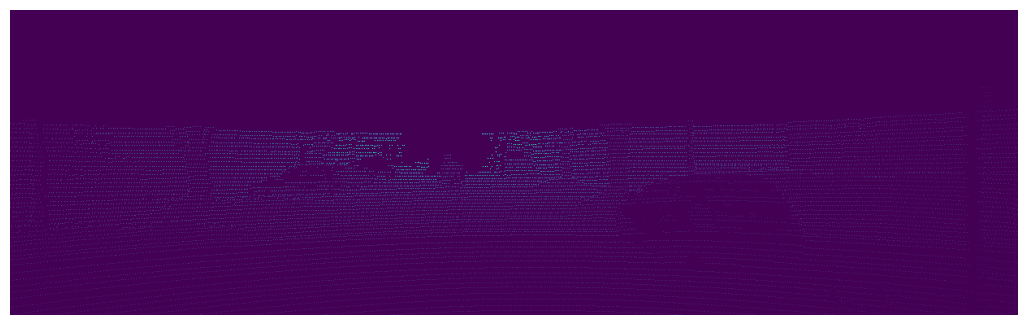

In [48]:
plt.figure(figsize=(13,5))
plt.imshow(render)
plt.axis('off')
plt.grid(False)

In [49]:
for i,d in enumerate(stereo_depth[200:, :].flatten()):
    if render[200:, :].flatten()[i] == 0:
        continue
    print('Stereo Depth: ', d, 'Lidar Depth: ', render[200:, :].flatten()[i])
    if i>1000:
        break

Stereo Depth:  24.040143190661475 Lidar Depth:  25.08251557273636
Stereo Depth:  36.99590898203592 Lidar Depth:  38.18529319193908
Stereo Depth:  37.67266341463414 Lidar Depth:  38.15661260397033
Stereo Depth:  37.67266341463414 Lidar Depth:  38.04491130916553
Stereo Depth:  38.13775802469135 Lidar Depth:  38.22929779114657
Stereo Depth:  38.37463850931676 Lidar Depth:  37.93287208133164
Stereo Depth:  38.61447999999999 Lidar Depth:  37.970212888663504
Stereo Depth:  38.61447999999999 Lidar Depth:  38.78230455441224
Stereo Depth:  39.10327088607594 Lidar Depth:  43.35304297366147
Stereo Depth:  52.80612649572648 Lidar Depth:  43.92954268130661
Stereo Depth:  56.681805504587146 Lidar Depth:  52.296451988896685
Stereo Depth:  57.20663703703703 Lidar Depth:  53.01673964440458
Stereo Depth:  57.20663703703703 Lidar Depth:  53.154098455093575
Stereo Depth:  57.741278504672884 Lidar Depth:  53.17143027237011
Stereo Depth:  57.741278504672884 Lidar Depth:  53.19275972156243
Stereo Depth:  57.

In [50]:
pointcloud_frames = (pointcloud2image(next(handler2.pointclouds), handler2.imheight, handler2.imwidth, handler2.Tr, handler2.P0) for i in range(handler2.num_frames))

In [51]:
%matplotlib tk

In [52]:
handler2.reset_frames()

In [53]:
xs = []
ys = []
zs = []
compute_times = []
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev = 20, azim = 270)
ax.plot(handler2.gt[:, 0, 3], handler2.gt[:, 1, 3], handler2.gt[:, 2, 3], c='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z') 

stereo_l = handler2.images_left
stereo_r = handler2.images_right
poses = (gt for gt in handler2.gt)

for i in range(handler2.num_frames // 50):
    img_l = next(stereo_l)
    img_r = next(stereo_r)
    start = datetime.datetime.now()
    disp = compute_left_disparity_map(img_l, img_r, matcher="sgbm")
    disp /= disp.max()
    disp = (disp*255).astype('uint8')
    # disp = cv2.applyColorMap(disp, cv2.COLORMAP_RAINBOW)
    pcloud = (next(pointcloud_frames)*255)
    pcloud /= pcloud.max()
    pcloud = (pcloud*255).astype('uint8')
    
    gt = next(poses)
    xs.append(gt[0, 3])
    ys.append(gt[1, 3])
    zs.append(gt[2, 3])

    plt.plot(xs, ys, zs, c='chartreuse')
    plt.pause(0.0000000000000000001)
    cv2.imshow("Camera", img_l)
    cv2.imshow("Disparity Map", disp)
    cv2.imshow('LiDAR', pcloud)
    cv2.waitKey(1)

    end = datetime.datetime.now()
    compute_times.append(end - start)

plt.close()
cv2.destroyAllWindows()

Data type of disparity map:  <class 'numpy.ndarray'>


C:\Users\arun2\AppData\Local\Temp\ipykernel_14712\4200453288.py:22: RuntimeWarning: divide by zero encountered in divide
  disp /= disp.max()
C:\Users\arun2\AppData\Local\Temp\ipykernel_14712\4200453288.py:22: RuntimeWarning: invalid value encountered in divide
  disp /= disp.max()
C:\Users\arun2\AppData\Local\Temp\ipykernel_14712\4200453288.py:23: RuntimeWarning: invalid value encountered in cast
  disp = (disp*255).astype('uint8')


Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.ndarray'>
Data type of disparity map:  <class 'numpy.nda

In [54]:
def extract_images(images, detector='sift', mask = None):
    if detector == 'sift':
        det = cv2.SIFT_create()
        # det = cv2.xfeatures2d.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()

    kp, des = det.detectAndCompute(images, mask)
    return kp, des

In [55]:
def match_features(des1, des2, matching='BF', detector='sift', sort = True, k=2):
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck = False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING, crossCheck = False)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        
    matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)
        
    return matches

In [56]:
def visualize_matches(image1, kp1, image2, kp2, match):
    images_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16,6), dpi=100)
    plt.imshow(images_matches)
    plt.axis('off')

In [57]:
# matches = match_features(des0, des1, matching = 'BF', detector='sift', sort = False)

In [58]:
# matches[0][0].distance

In [59]:
# matches[0][1].distance

In [60]:
def filter_matches_distance(matches, dist_threshold=0.5):
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold * n.distance:
            filtered_match.append(m)
    return filtered_match

In [61]:
%matplotlib inline

Number of matches before filtering:  2931
Number of matches after filtering:  912
Time to compute matches and filter:  0:00:00.212452


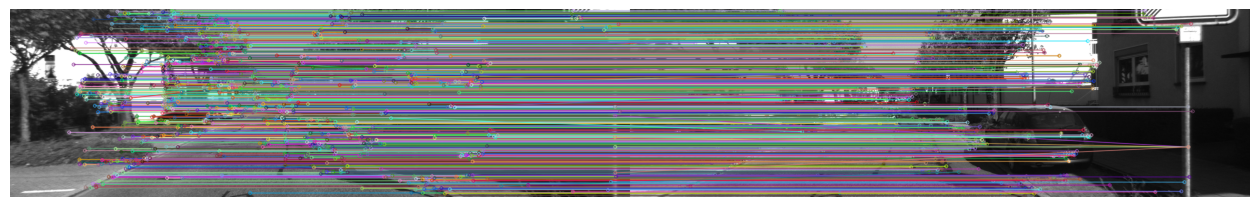

In [62]:
image_left = handler2.first_image_left
image_right = handler2.first_image_right
image_plus1 = handler2.second_image_left
start = datetime.datetime.now()
kp0, des0 = extract_images(image_left, detector='sift', mask=mask)
kp1, des1 = extract_images(image_right, detector='sift', mask=mask)
matches = match_features(des0, des1, matching = 'BF', detector='sift', sort = False)
# matches = [match[0] for match in matches]
print('Number of matches before filtering: ', len(matches))
matches = filter_matches_distance(matches, 0.7)
print('Number of matches after filtering: ', len(matches))
end = datetime.datetime.now()
print('Time to compute matches and filter: ', end-start)
visualize_matches(image_left, kp0, image_right, kp1, matches)

In [63]:
# image_left = handler2.first_image_left
# image_right = handler2.first_image_right
# image_plus1 = handler2.second_image_left
# start = datetime.datetime.now()
# kp0, des0 = extract_images(image_left, detector='orb', mask=mask)
# kp1, des1 = extract_images(image_right, detector='orb', mask=mask)
# matches = match_features(des0, des1, matching = 'BF', detector='orb', sort = False)
# # matches = [match[0] for match in matches]
# print('Number of matches before filtering: ', len(matches))
# matches = filter_matches_distance(matches, 0.5)
# print('Number of matches after filtering: ', len(matches))
# end = datetime.datetime.now()
# print('Time to compute matches and filter: ', end-start)
# visualize_matches(image_left, kp0, image_plus1, kp1, matches)

In [64]:
kp1[0].pt

(95.90751647949219, 61.535194396972656)

In [65]:
print("Depth Shape: ", depth.shape)
print("Image Left Shape: ", handler2.first_image_left.shape)

Depth Shape:  (376, 1241)
Image Left Shape:  (376, 1241)


In [66]:
def estimate_motion(matches, kp1, kp2, k, depth1, max_depth=3000):
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in matches])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in matches])

    cx = k[0,2]
    cy = k[1,2]
    fx = k[0,0]
    fy = k[1,1]

    object_points = np.zeros((0, 3))
    delete = []

    for i, (u,v) in enumerate(image1_points):
        z = depth1[int(round(v)), int(round(u))]
        
        if z>max_depth:
            delete.append(i)
            continue

        x = (u-cx)*z/fx
        y = (v-cy)*z/fy
        object_points = np.vstack((object_points, np.array([x,y,z])))

        # object_points = np.vstack([object_points, np.linalg.inv(k).dot(z*np.array([u,v,1]))])

    image1_points = np.delete(image1_points, delete, 0)
    image2_points = np.delete(image2_points, delete, 0)

    _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)

    rmat, _ = cv2.Rodrigues(rvec)
    
    return rmat, tvec, image1_points, image2_points

In [67]:
k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(handler2.P0)

In [68]:
rmat, tvec, image1_points, image2_points = estimate_motion(matches, kp0, kp1, k, depth, max_depth=3000)
print("Rotation Matrix: ", rmat.round(4))
print("Translation Vector: ", tvec.round(4))
# print("Image 1 Points: ", image1_points)
# print("Image 2 Points: ", image2_points)

Rotation Matrix:  [[ 1.e+00  1.e-04 -0.e+00]
 [-1.e-04  1.e+00 -2.e-04]
 [ 0.e+00  2.e-04  1.e+00]]
Translation Vector:  [[-5.345e-01]
 [-5.000e-04]
 [ 5.800e-03]]


In [69]:
transformation_matrix = np.hstack((rmat, tvec))
print("Transformation Matrix: ", transformation_matrix.round(4))

Transformation Matrix:  [[ 1.000e+00  1.000e-04 -0.000e+00 -5.345e-01]
 [-1.000e-04  1.000e+00 -2.000e-04 -5.000e-04]
 [ 0.000e+00  2.000e-04  1.000e+00  5.800e-03]]


In [70]:
np.printoptions(suppress=True)
handler2.gt[1].round(4)
print("Ground Truth: ", handler2.gt[1].round(4))

Ground Truth:  [[ 1.000e+00  5.000e-04 -2.100e-03 -4.690e-02]
 [-5.000e-04  1.000e+00 -1.200e-03 -2.840e-02]
 [ 2.100e-03  1.200e-03  1.000e+00  8.587e-01]]


In [71]:
homo_trans_mat = np.eye(4)
homo_trans_mat[:3, :3] = rmat
homo_trans_mat[:3, 3] = tvec.reshape(3)
print("Homogenous Transformation Matrix: ", homo_trans_mat.round(4))

Homogenous Transformation Matrix:  [[ 1.000e+00  1.000e-04 -0.000e+00 -5.345e-01]
 [-1.000e-04  1.000e+00 -2.000e-04 -5.000e-04]
 [ 0.000e+00  2.000e-04  1.000e+00  5.800e-03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


In [72]:
np.linalg.inv(homo_trans_mat)

array([[ 9.99999989e-01, -1.45522484e-04,  1.11284131e-05,
         5.34492323e-01],
       [ 1.45519801e-04,  9.99999960e-01,  2.40664948e-04,
         5.32914320e-04],
       [-1.11634348e-05, -2.40663326e-04,  9.99999971e-01,
        -5.83693727e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [73]:
homo_start = np.eye(4)
homo_start[:3, :] = handler2.gt[0]
second_pose = homo_start.dot(homo_trans_mat)
print("Second Pose: ", second_pose.round(4))

Second Pose:  [[ 1.000e+00  1.000e-04 -0.000e+00 -5.345e-01]
 [-1.000e-04  1.000e+00 -2.000e-04 -5.000e-04]
 [ 0.000e+00  2.000e-04  1.000e+00  5.800e-03]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]


In [74]:
def visual_odometry(handler, detector='sift', matching='BF', filt_matches_distance=None, stereo_matcher='sgbm', mask=None, subset = None, plot=False):
    # Determine if handler has LiDAR data
    lidar = handler.lidar

    print("Generating disparities with stereo{}".format(str.upper(stereo_matcher)))
    print("Detecting features with {} and matching with {}".format(str.upper(detector), str.upper(matching)))

    if filt_matches_distance is not None:
        print("Filtering feature matches at threshold of {}*distance".format(filt_matches_distance))
    if lidar:
        print("Improving stereo depth using LiDAR data")
    if subset is not None:
        num_frames = subset
    else:
        num_frames = handler.num_frames
    
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(111, projection='3d')
        ax.view_init(elev = 20, azim = 270)
        xs = handler.gt[:,0,3]
        ys = handler.gt[:,1,3]
        zs = handler.gt[:,2,3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')

    # Establish a homogenous transformation matrix. First pose is identity
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    #Decompose left camera projection matrix to get intrinsic parameters
    k_left, r_left, t_left, _, _, _, _ = cv2.decomposeProjectionMatrix(handler.P0)
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)

    # Iterate through all frames of the sequence
    for i in range(num_frames-1):
        start = datetime.datetime.now()

        if handler.low_memory:
            image_left = image_plus1
            image_plus1 = next(handler.images_left)
            image_right = next(handler.images_right)
            # depth = next(handler.pointclouds)
        else:
            image_left = handler.first_image_left
            image_plus1 = handler.images_left[i+1]
            image_right = handler.images_right[i]
            # depth = handler.depths[i]

        depth = stereo_to_depth(image_left, image_right, P0= handler.P0, P1= handler.P1, matcher=stereo_matcher)

        if lidar:
            if handler.low_memory:
                pointcloud = next(handler.pointclouds)
            else:
                pointcloud = handler.pointclouds[i]
            
            lidar_depth = pointcloud2image(pointcloud, imheight=imheight, imwidth=imwidth, Tr=handler.Tr, P0=handler.P0)
            indices = np.where(lidar_depth > 0)
            depth[indices] = lidar_depth[indices]

        # Get keypoints and descriptors
        kp0, des0 = extract_images(image_left, mask=mask)
        kp1, des1 = extract_images(image_plus1, mask=mask)

        # Get matches betweeen features detected in two subsequent frames
        matches_unfilt = match_features(des0, des1, matching = matching, detector=detector)

        # print('Number of matches before filtering: ', len(matches_unfilt))

        # Filter matches if a distance threshold is specified
        if filt_matches_distance is not None:
            matches_main = filter_matches_distance(matches_unfilt, filt_matches_distance)
        else:
            matches_main = matches_unfilt

        # print('Number of matches before filtering: ', len(matches))

        # Estimate motion between frames
        rmat, tvec, image1_points, image2_points = estimate_motion(matches_main, kp0, kp1, k_left, depth, max_depth=3000)

        # Create a blank homogeneous transformation matrix
        Tmat = np.eye(4)
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T

        T_tot = T_tot.dot(np.linalg.inv(Tmat))

        trajectory[i+1, :, :] = T_tot[:3, :]

        end = datetime.datetime.now()
        print('Time to compute frame {}: '.format(i+1), end-start)

        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]         
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(0.0000000000000000001)

    if plot:
        plt.close()

    return trajectory

In [75]:
%matplotlib tk

In [76]:
trajectory_test = visual_odometry(handler2, detector='sift', matching='BF', filt_matches_distance=0.7, stereo_matcher='sgbm', mask=mask, subset = None, plot=True)

Generating disparities with stereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.7*distance
Improving stereo depth using LiDAR data
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.023874
Time to compute frame 1:  0:00:00.253532
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.044004
Time to compute frame 2:  0:00:00.289223
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.024087
Time to compute frame 3:  0:00:00.308795
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.025016
Time to compute frame 4:  0:00:00.260056
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.026048
Time to compute frame 5:  0:00:00.289256
Data type of disparity map:  <class 

C:\Users\arun2\AppData\Local\Temp\ipykernel_14712\654748392.py:19: RuntimeWarning: invalid value encountered in cast
  pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')


Time to compute frame 184:  0:00:00.310988
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.024517
Time to compute frame 185:  0:00:00.282506
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.024002
Time to compute frame 186:  0:00:00.259914
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.027003
Time to compute frame 187:  0:00:00.282221
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.025002
Time to compute frame 188:  0:00:00.273703
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.026040
Time to compute frame 189:  0:00:00.337252
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.025742
Time to compute frame 190:  0:00:00.299900
Data type

C:\Users\arun2\AppData\Local\Temp\ipykernel_14712\654748392.py:19: RuntimeWarning: invalid value encountered in cast
  pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')


Time to compute frame 1078:  0:00:00.445198
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.045740
Time to compute frame 1079:  0:00:00.392792
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.024663
Time to compute frame 1080:  0:00:00.437073
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.030502
Time to compute frame 1081:  0:00:00.397111
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.033931
Time to compute frame 1082:  0:00:00.406998
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.030641
Time to compute frame 1083:  0:00:00.343652
Data type of disparity map:  <class 'numpy.ndarray'>
Time to compute disparity map using StereoSGBM 0:00:00.061552
Time to compute frame 1084:  0:00:00.388362
Da